In [273]:
import numpy as np
import yaml
import os
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 

from utils.load_datasets import load_dataset
from models import vgg
from models.cvae import CVAE
from models.vgg_vmmix import BiternionVGGMixture

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dataset_name = "CAVIAR-o" #"IDIAP" #"CAVIAR-o"
dataset_path = 'data/CAVIAR-o.pkl.gz' #'data//IDIAP.pkl' #'data/CAVIAR-o.pkl.gz' #
net_output = 'pan'
model_type = 'cvae'

In [3]:
(xtr, ytr_bit, ytr_deg), (xval, yval_bit, yval_deg), (xte, yte_bit, yte_deg) = load_dataset(dataset_name,
                                                                                            dataset_path,
                                                                                            net_output)

image_height, image_width, n_channels = xtr.shape[1], xtr.shape[2], xtr.shape[3]

In [276]:
if dataset_name=='CAVIAR-o':
    pretrained_path = 'pretrained_models/CAVIAR-o'

vggbit_cosine_config_path = os.path.join(pretrained_path, 'cosine/model.best.params.yml')
vggbit_cosine_weights_path = os.path.join(pretrained_path, 'cosine/model.best.weights.hdf5')
vggbit_likelihood_config_path = os.path.join(pretrained_path, 'likelihood/model.best.params.yml')
vggbit_likelihood_weights_path =  os.path.join(pretrained_path, 'likelihood/model.best.weights.hdf5')
vmmix_config_path =  os.path.join(pretrained_path, 'vm_mixture/model.best.params.yml')
vmmix_weights_path =  os.path.join(pretrained_path, 'vm_mixture/model.best.weights.hdf5')
cvae_config_path =  os.path.join(pretrained_path, 'cvae/model.trial_0.params.yml')
cvae_weights_path =  os.path.join(pretrained_path, 'cvae/model.trial_0.best.weights.hdf5')

In [270]:
def load_config(net_config_path):
    with open(net_config_path, 'r') as f:
        net_config = yaml.load(f)
    return net_config

vggbit_cosine_model = vgg.BiternionVGG(image_height=image_height,
                                image_width=image_width,
                                n_channels=3,
                                predict_kappa=False,
                                loss_type='cosine',
                                **load_config(vggbit_cosine_config_path))
vggbit_cosine_model.load_weights(vggbit_cosine_weights_path)
_ = vggbit_cosine_model.finetune_kappa(xval, yval_bit, max_kappa=1000)

vggbit_likelihood_model = vgg.BiternionVGG(image_height=image_height,
                                image_width=image_width,
                                n_channels=3,
                                predict_kappa=True,
                                loss_type='vm_likelihood',
                                **load_config(vggbit_likelihood_config_path))
vggbit_likelihood_model.load_weights(vggbit_likelihood_weights_path)

vmmix_model = BiternionVGGMixture(image_height=image_height,
                            image_width=image_width,
                            n_channels=3,
                            **load_config(vmmix_config_path))

vmmix_model.load_weights(vmmix_weights_path)
    


using cosine loss..
using likelihood loss..


In [275]:
cvae_weights_path

'pretrained_models/CAVIAR-o/cvae/model.trial_0.best.weights.hdf5'

In [279]:
from models.cvae import CVAE

cvae_model = CVAE(image_height=image_height,
                 image_width=image_width,
                 n_channels=n_channels,
                 **load_config(cvae_config_path))

#cvae_model.load_weights(cvae_weights_path)


kl_weight : 1.000000



ValueError: Layer #0 (named "sequential_46" in the current model) was found to correspond to layer sequential_1 in the save file. However the new layer sequential_46 expects 40 weights, but the saved weights have 38 elements.

In [272]:
def eval_all_models(x, y_deg, data_part):
    
    results = {}
    
    print("*****EVALUATING ON %s*****"%data_part)
    print("evaluating VGGBit (cosine loss)..")
    results['cosine'] = vggbit_cosine_model.evaluate(x, y_deg, data_part, return_per_image=True)
    print("evaluating VGGBit (likelihood loss)..")
    results['likelihood'] = vggbit_likelihood_model.evaluate(x, y_deg, data_part, return_per_image=True)
    print("evaluating VM-Mixture..")
    results['mixture'] = vmmix_model.evaluate(x, y_deg, data_part, return_per_image=True)
    print("evaluating CVAE..")
    results['cvae'] = cvae_model.evaluate(x, y_deg, data_part, return_per_image=True)
    
    return results

In [1013]:
starting_frame = 0
n_frames = 100
frames = np.arange(starting_frame, starting_frame+n_frames)
n_samples = 10
xvals =  np.arange(0, 2*np.pi, 0.01)

results = eval_all_models(xte[frames], yte_deg[frames], 'test')

pdfs_dict = {}

vggcosine_acc_pdf = vggbit_cosine_model.pdf(xte[frames], xvals)

vgglikelihood_acc_pdf = vggbit_likelihood_model.pdf(xte[frames], xvals)

vmmix_pdfs, vmmix_acc_pdf = vmmix_model.pdf(xte[frames], xvals)

cvae_samples_pdfs, cvae_acc_pdfs = cvae_model.pdf(xte[frames], xvals, n_samples=n_samples)

*****EVALUATING ON test*****
evaluating VGGBit (cosine loss)..
MAAD error (test) : 5.518027 pm 0.697660SEM
log-likelihood (test) : 0.424579 pm 0.103572SEM
evaluating VGGBit (likelihood loss)..
MAAD error (test) : 3.962524 pm 0.587055SEM
log-likelihood (test) : 1.178304 pm 0.096673SEM
evaluating VM-Mixture..
MAAD error (test) : 4.287823 pm 1.751077SEM
log-likelihood (test) : 2.282778 pm 0.208613SEM
evaluating CVAE..
MAAD error (test) : 11.885272 pm 1.346678SEM
ELBO (test) : -0.181416 pm 0.065752SEM
Approx Log-Likelihood, importance sampling (test) : -0.169530 pm 0.066380SEM
KL-div (test) : 0.007112 pm0.000376SEM


In [10]:
def plot_pdf(axis, xvals, pdf, ypred=None, gt_val=None, title=''):
    
    axis.set_xticks(([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]))
    axis.set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]) 
    axis.set_xlim([-0.001, 2*np.pi+0.001])
    axis.set_ylim([0, 10.0])
    if gt_val is not None:
        axis.axvline(gt_val, color='red', label='gt')
    if ypred is not None:
        axis.axvline(ypred, color='blue', label='pred')
    axis.plot(xvals, pdf)
    axis.legend(loc=1)
    axis.set_title(title)
    return

In [9]:
def plot_image_results(im, fid, xvals, pdfs_dict, likelihoods_dict, maad_dict, ppreds_dict, ytr_rad):
    
    n_pdfs = len(pdfs_dict)
    
    fig, axs = plt.subplots(1, n_pdfs+1, figsize=(30, 5))
    
    axs[0].imshow(im)
    
    i=1
    
    for pdf_name, pdf in pdfs_dict.items():
        ypred_rad = np.deg2rad(ppreds_dict[pdf_name])
        title = "%s (logL$\\approx$%.2f, AAD=%.2f°)" % (pdf_name, likelihoods_dict[pdf_name], maad_dict[pdf_name])
        plot_pdf(axs[i], xvals, pdf, ypred_rad, ytr_rad, title)
        i+=1
    
    # plot_pdf(axs[1], xvals, acc_pdf, ytr_rad)
    #for sid in range(0, n_components):
        #plot_pdf(axs[2], xvals, samples_pdf[sid], ytr_rad)
    
    fig.suptitle("Frame ID : %d" % fid)
    plt.show()
    
    return

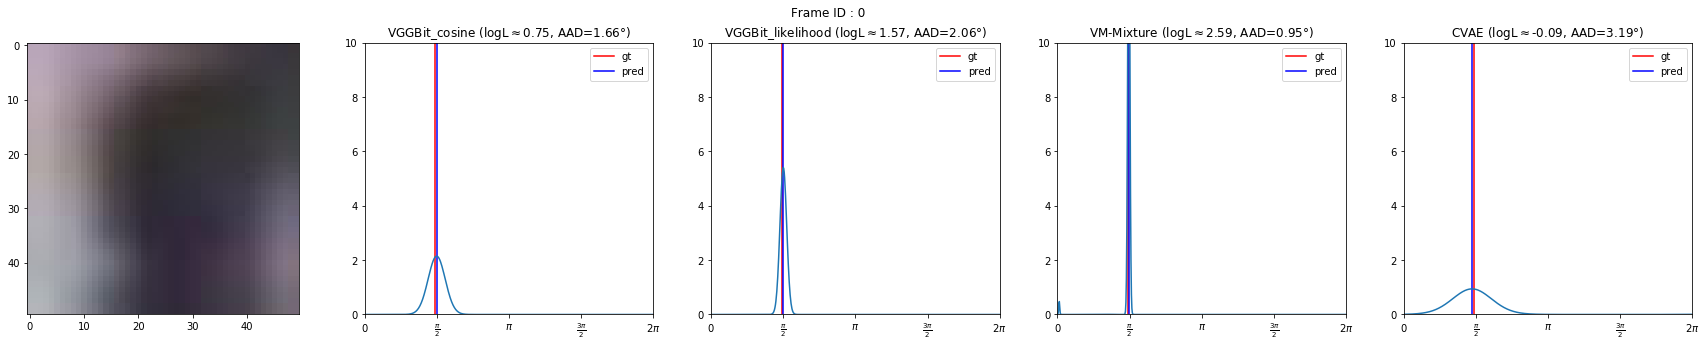

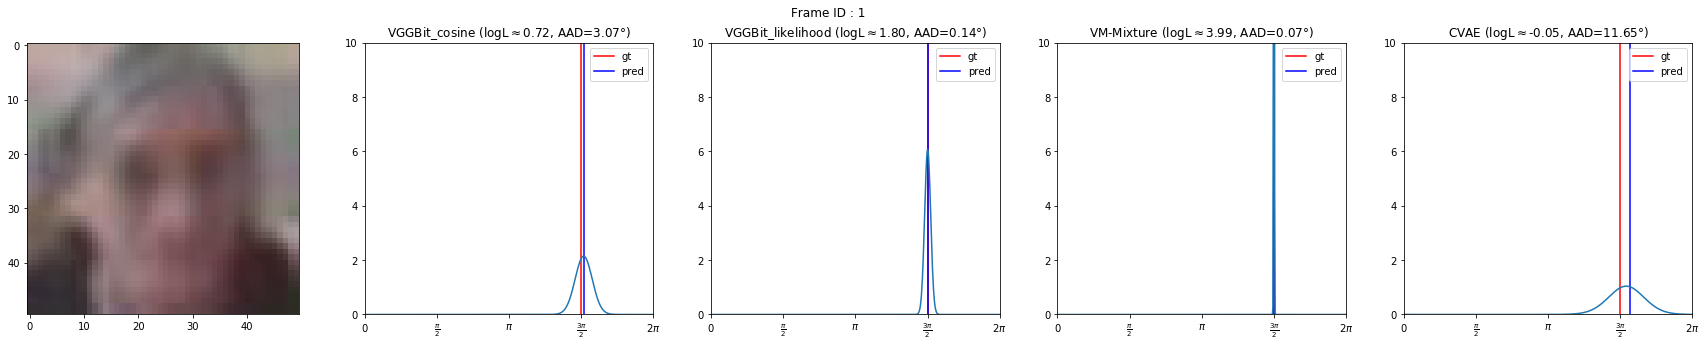

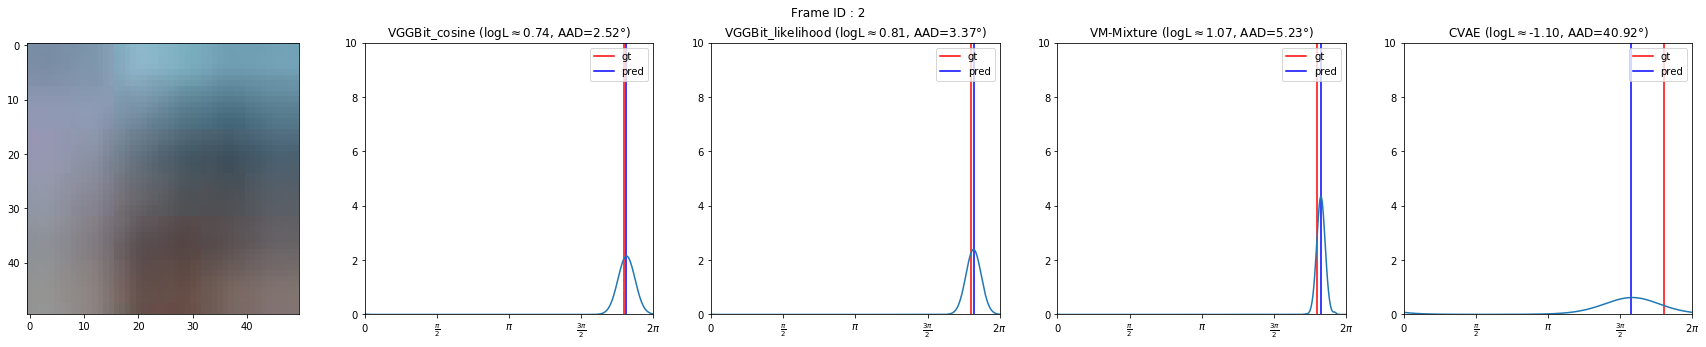

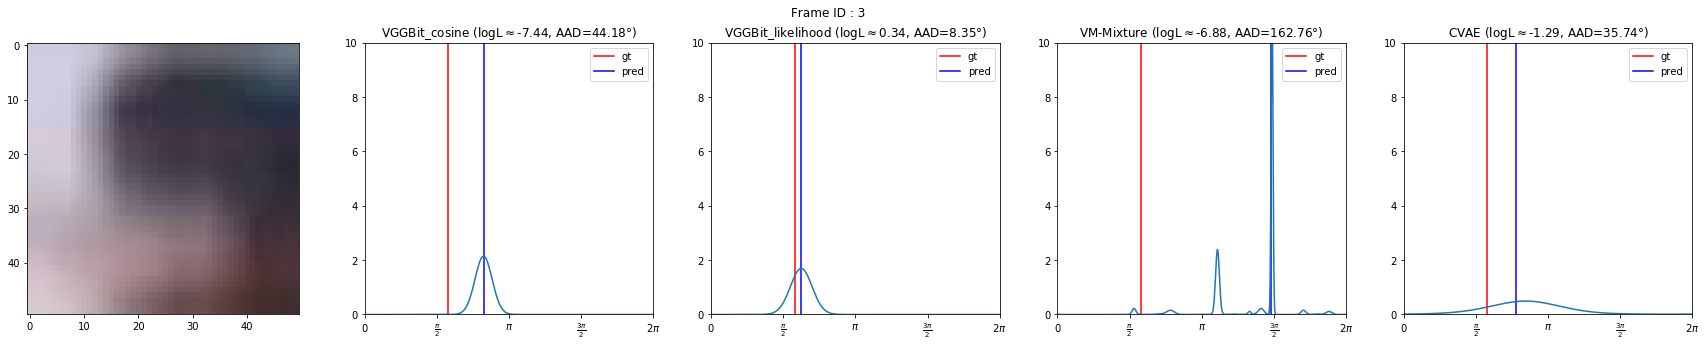

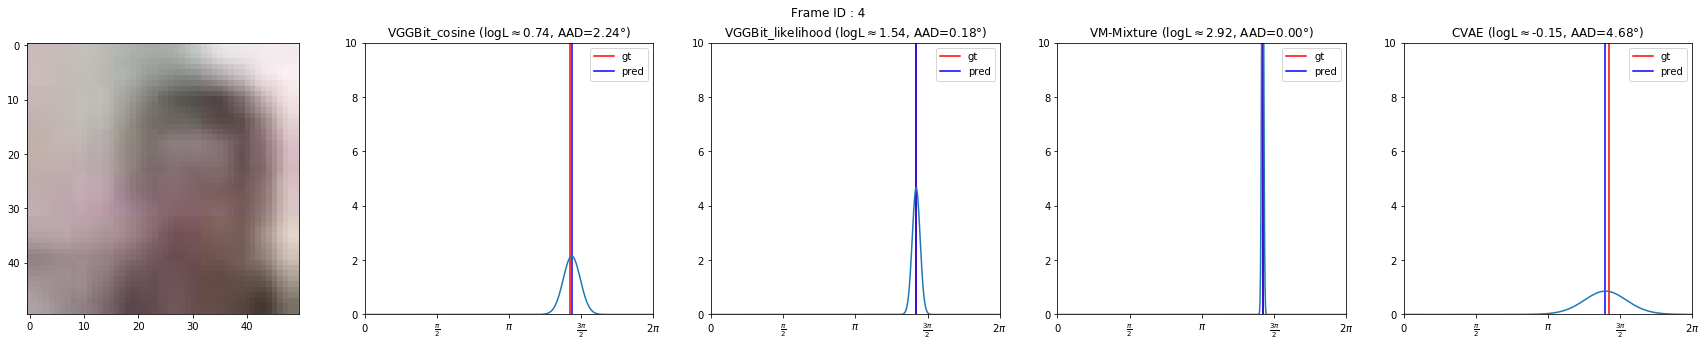

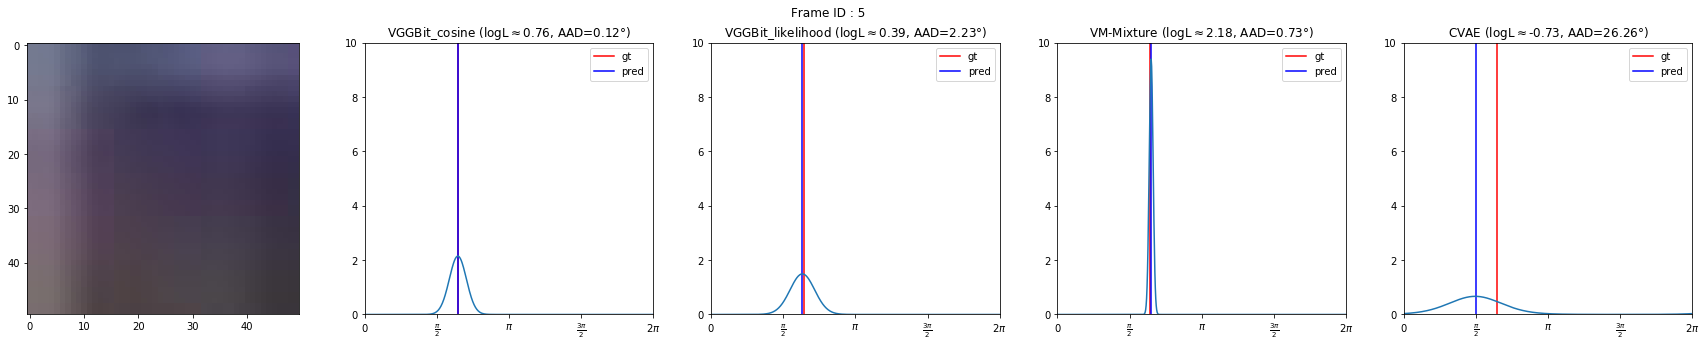

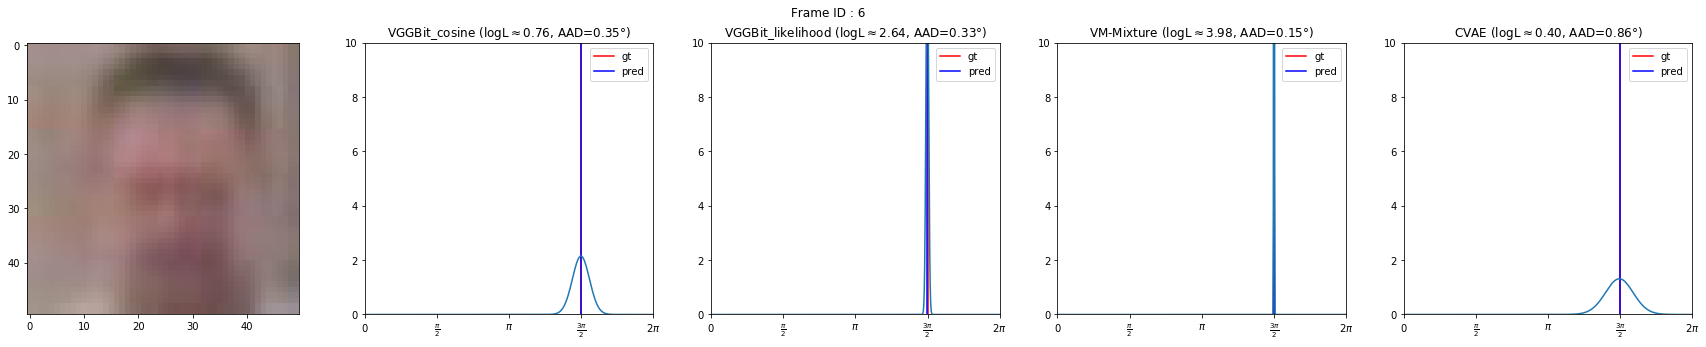

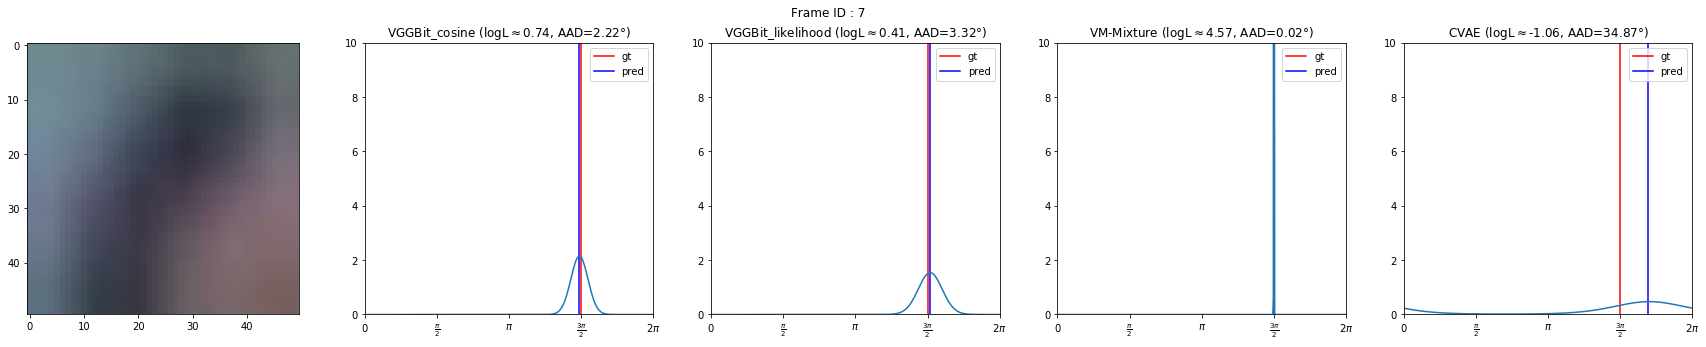

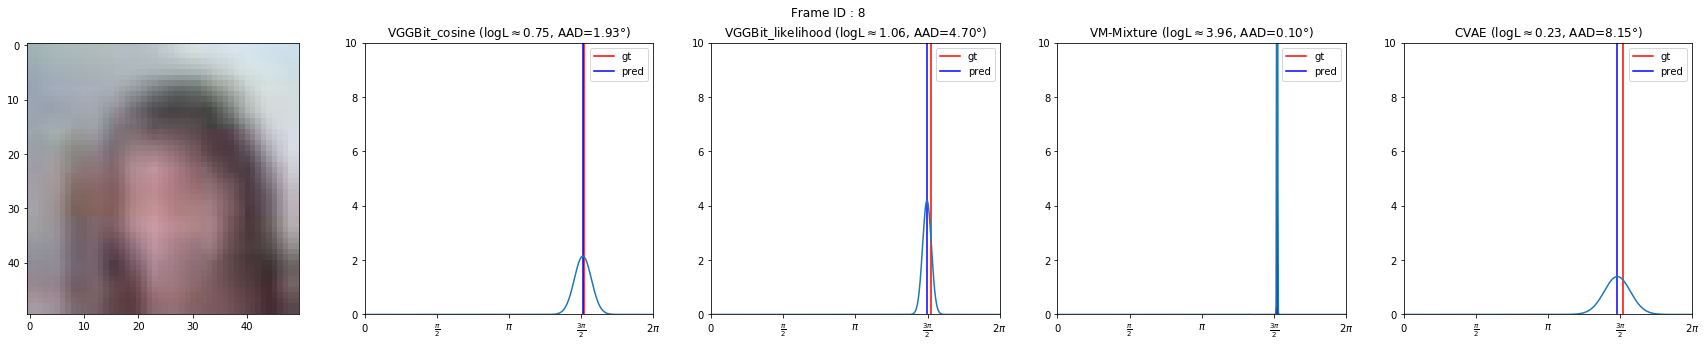

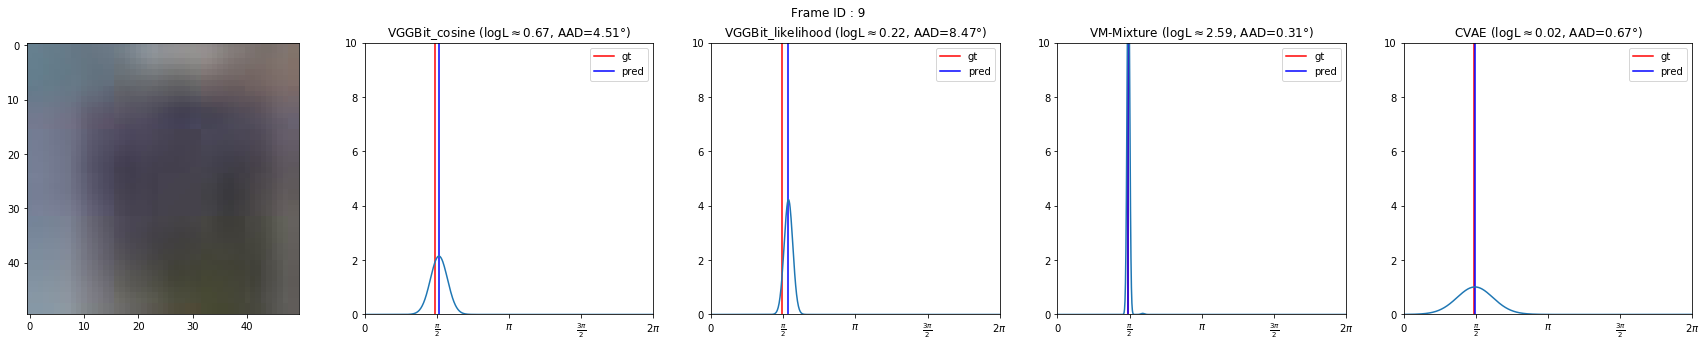

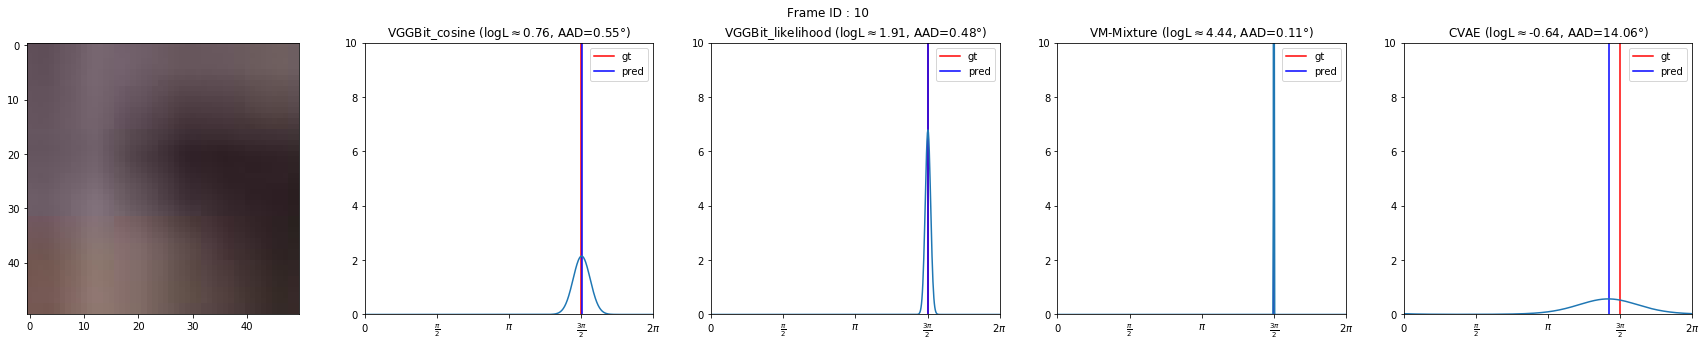

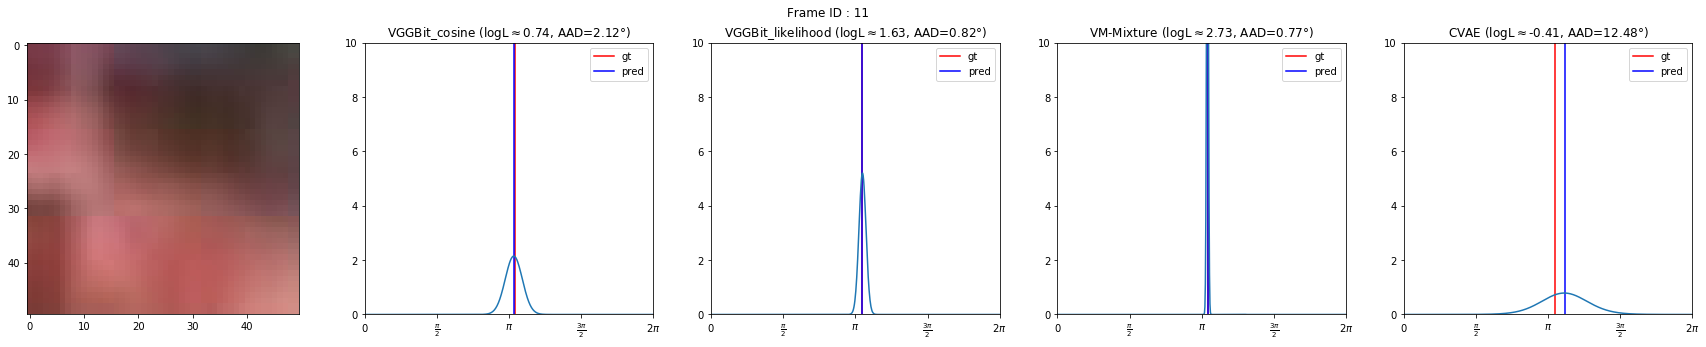

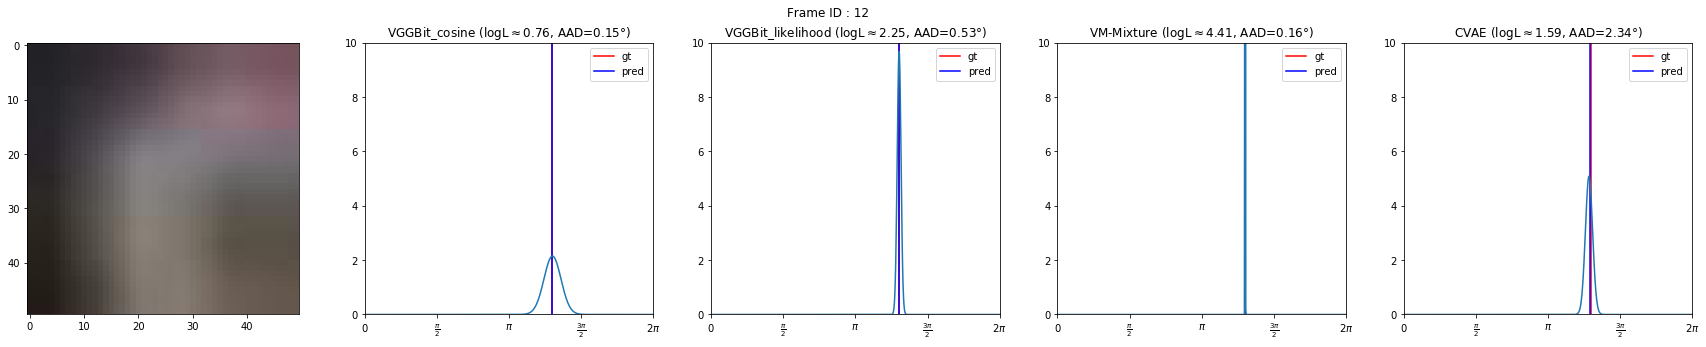

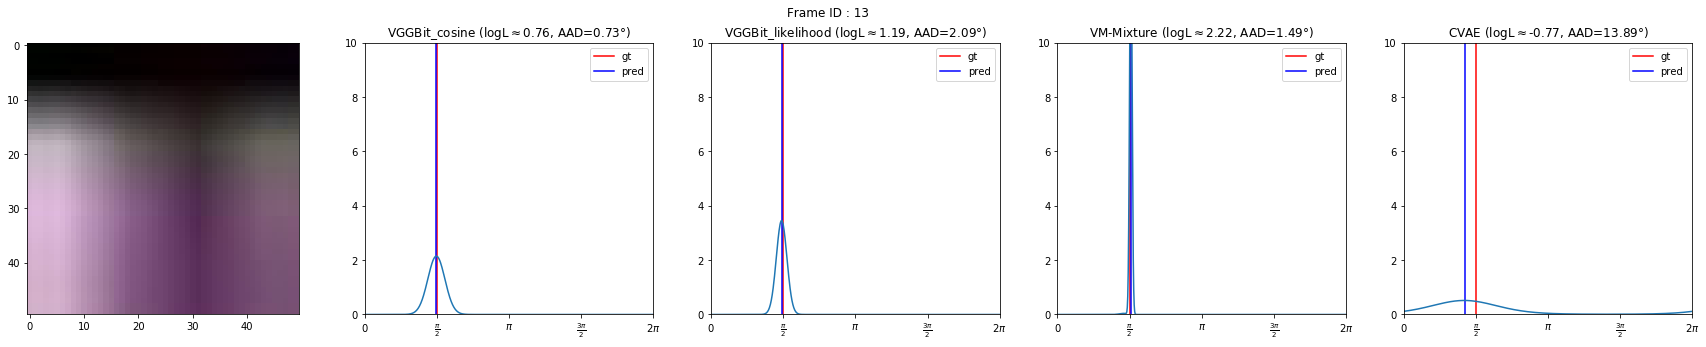

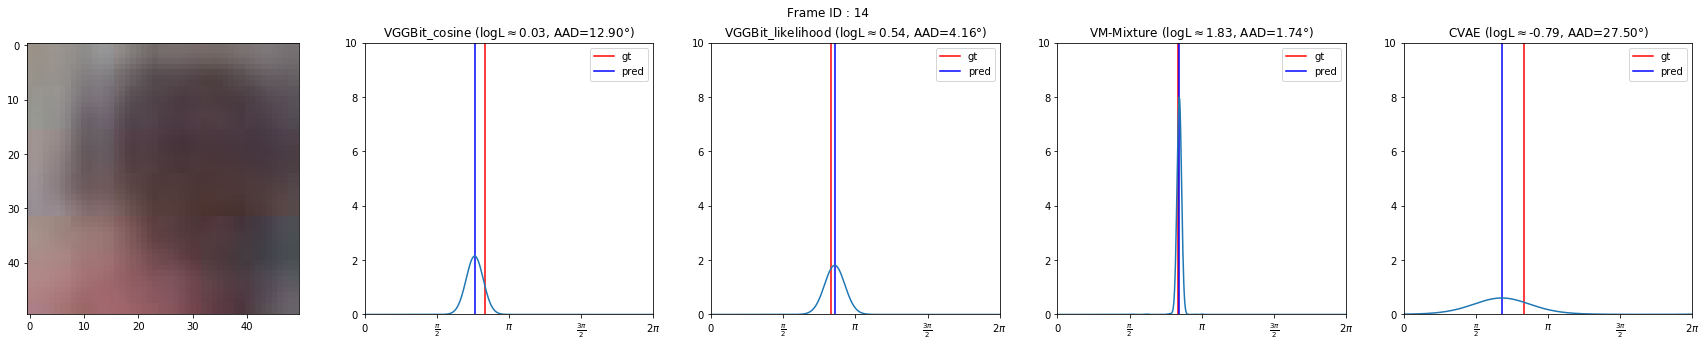

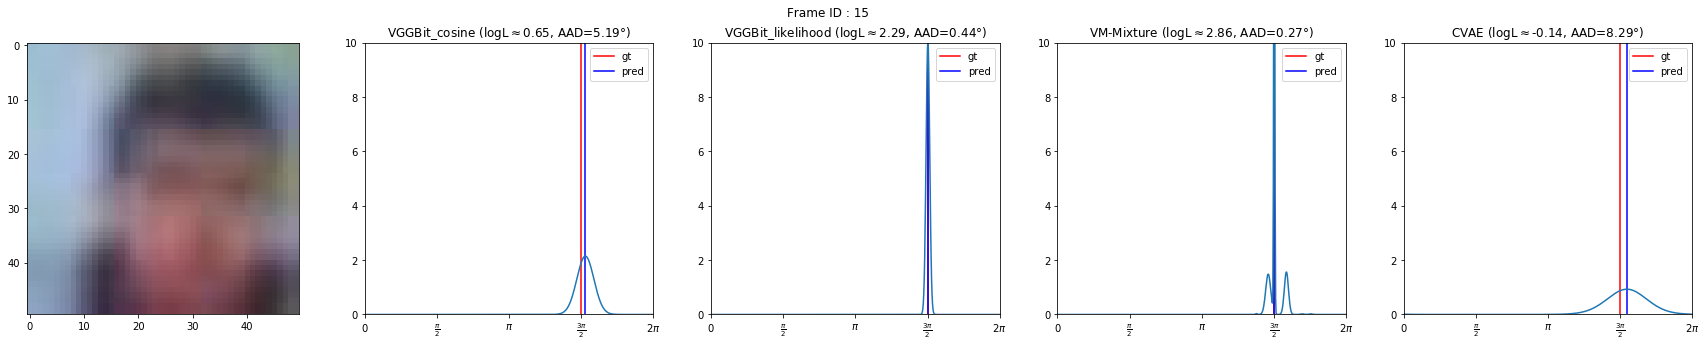

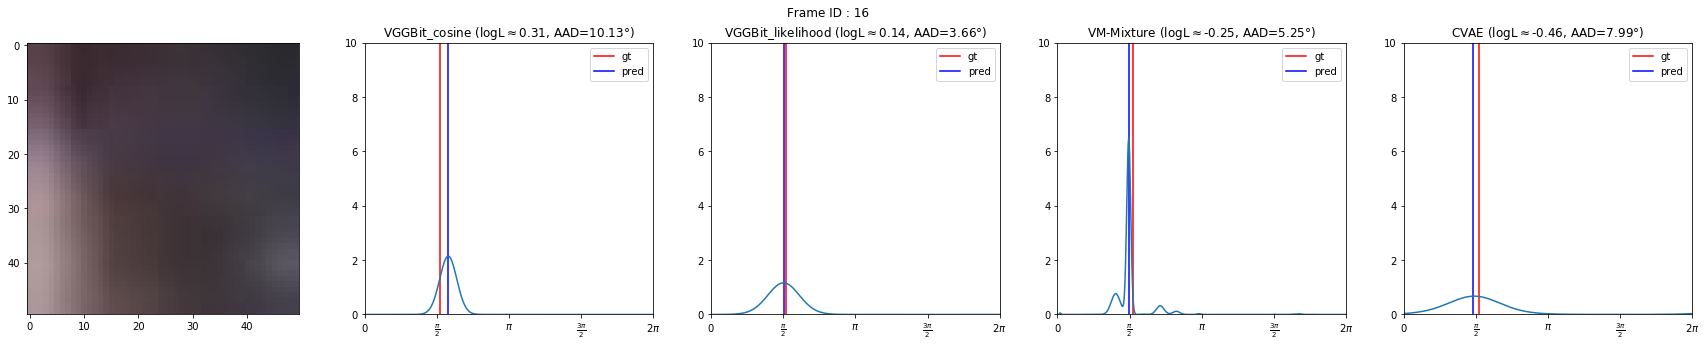

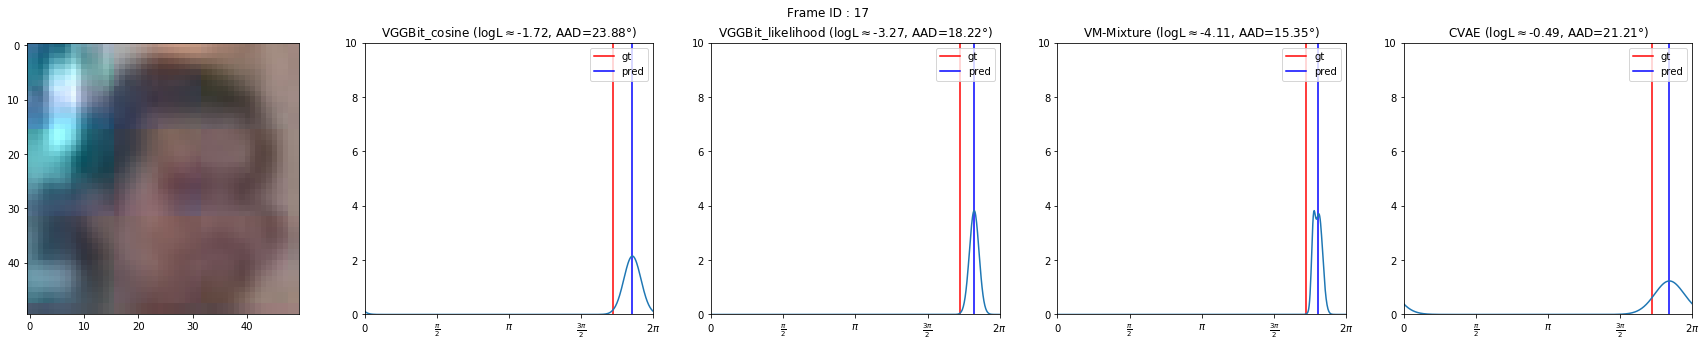

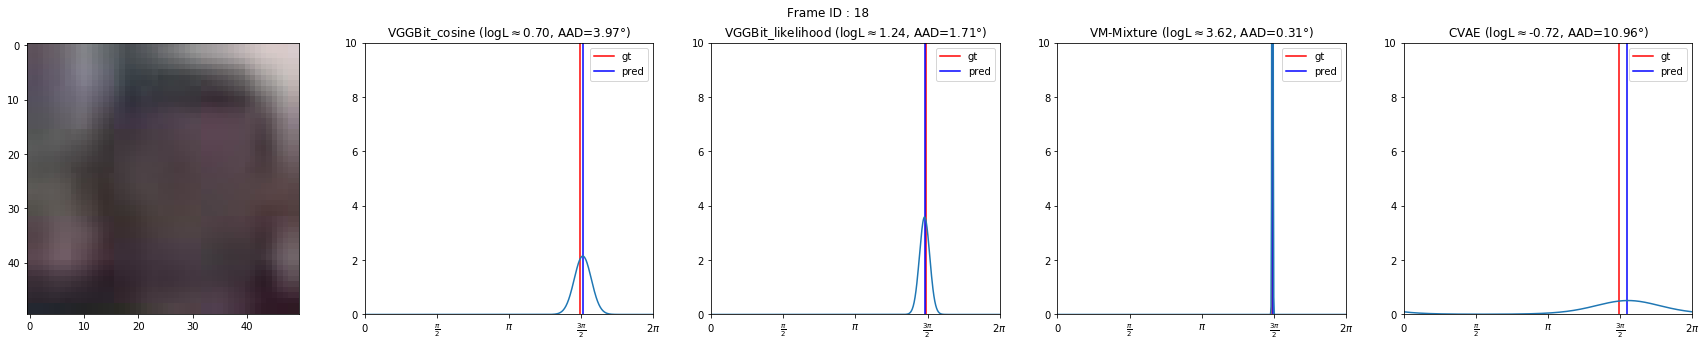

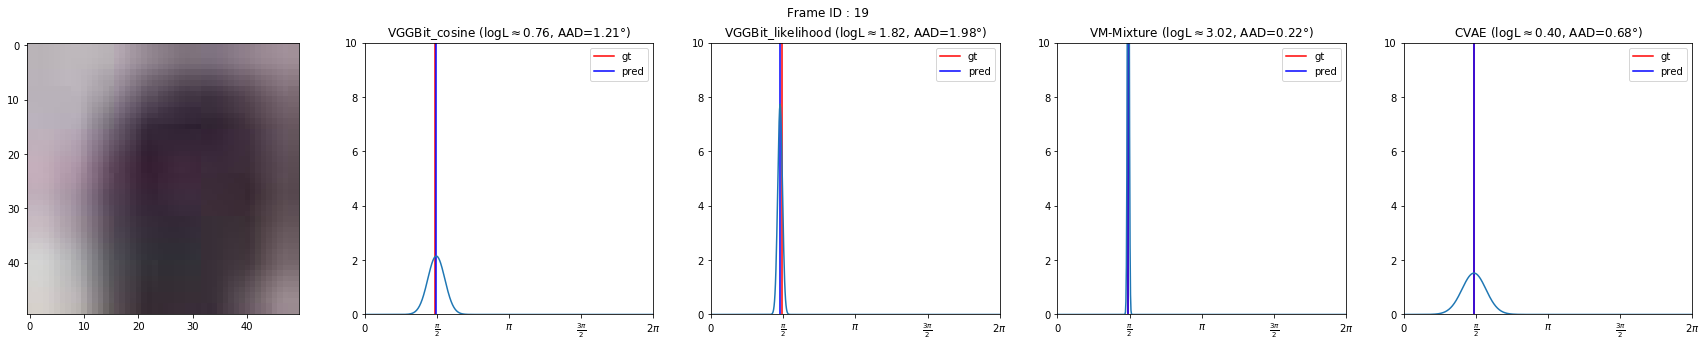

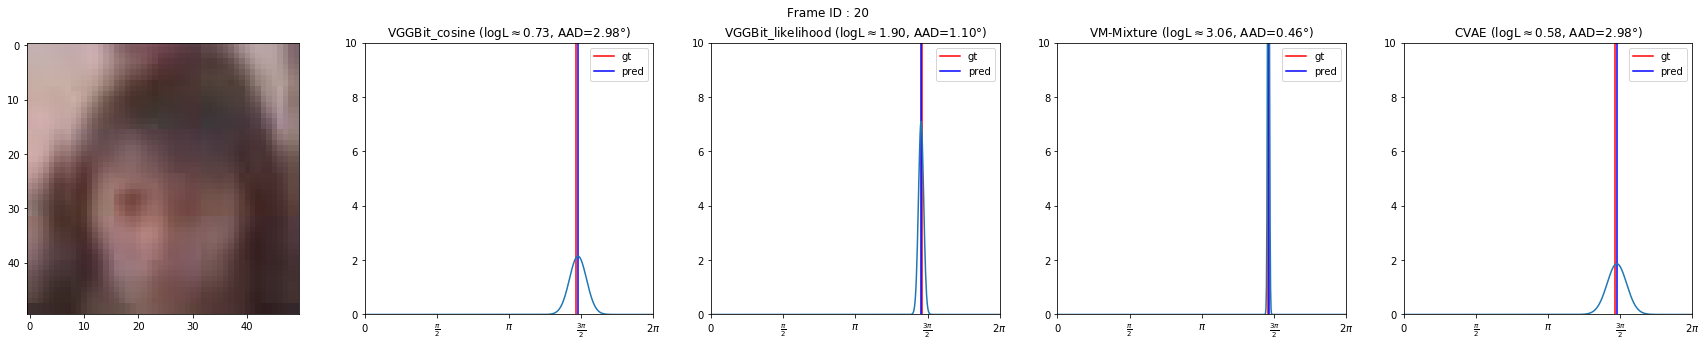

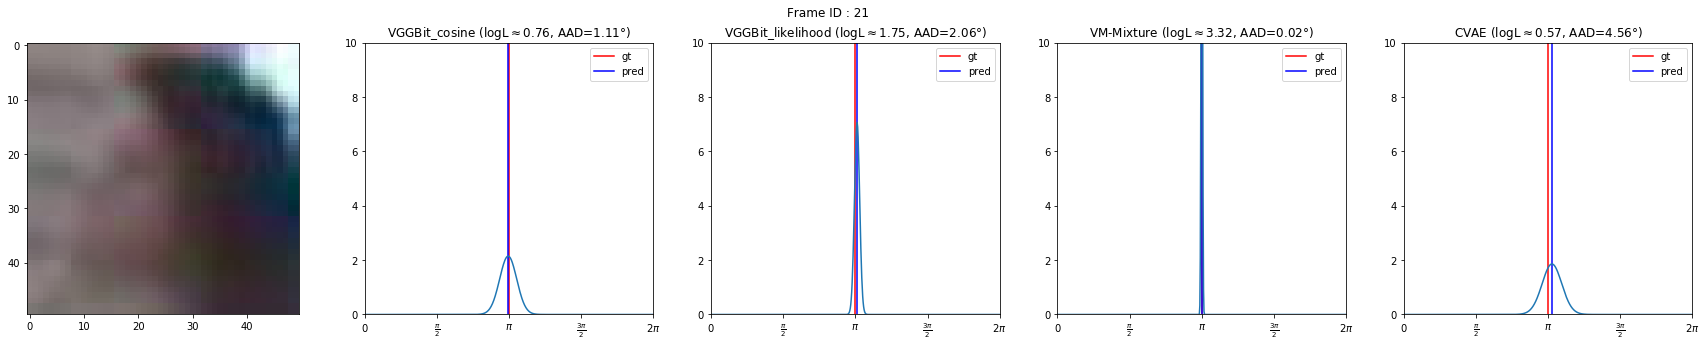

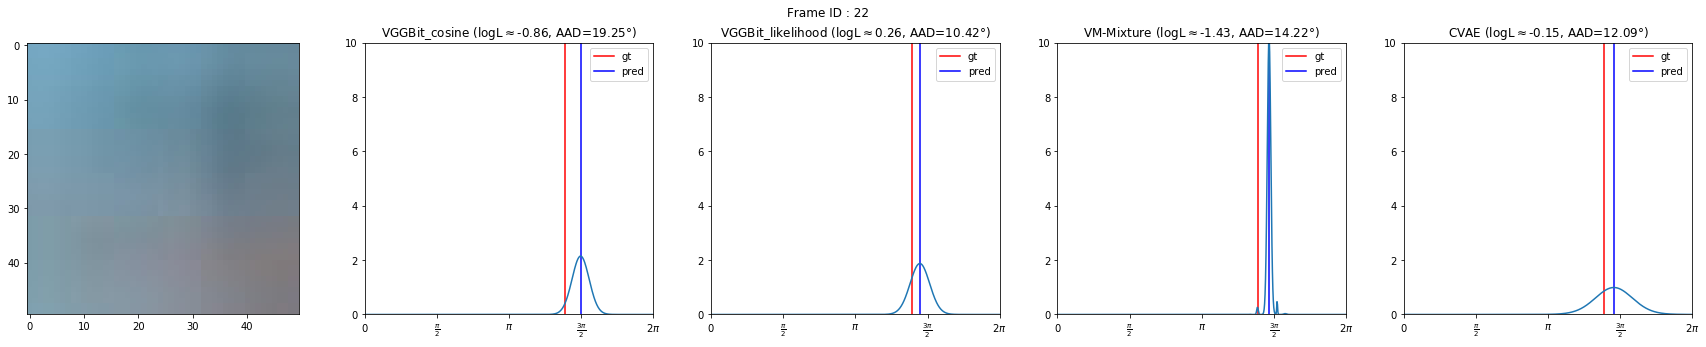

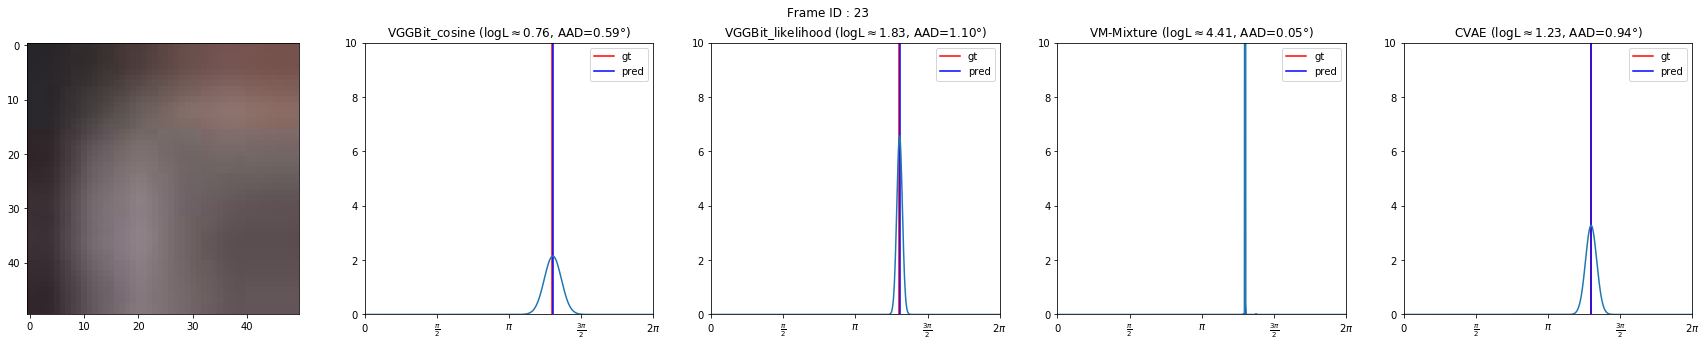

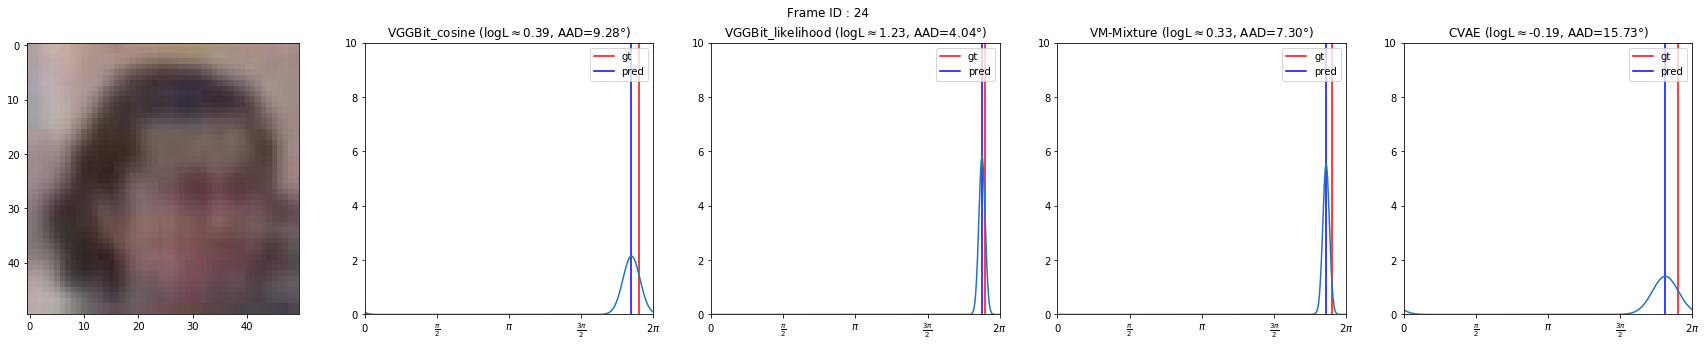

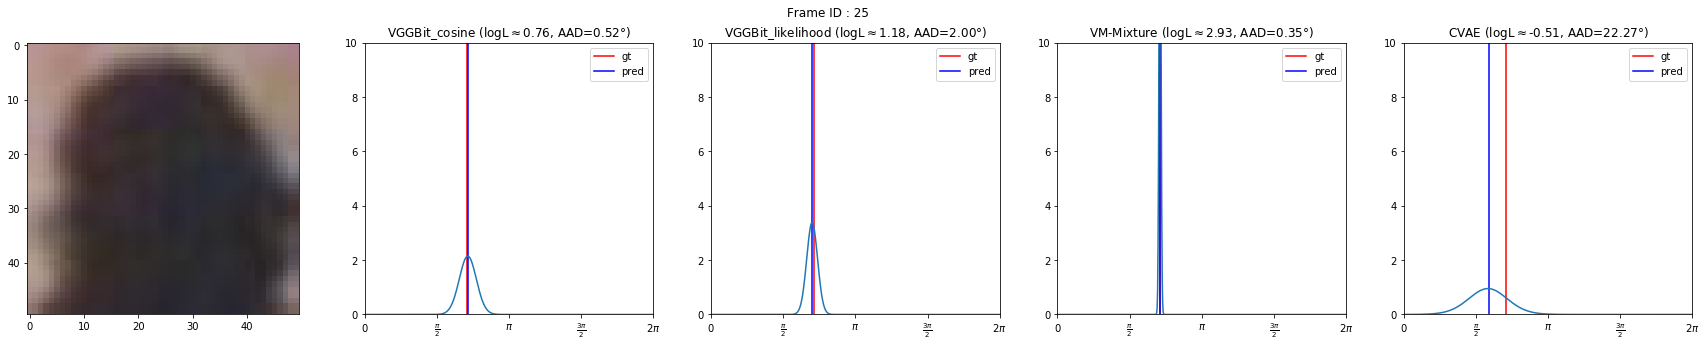

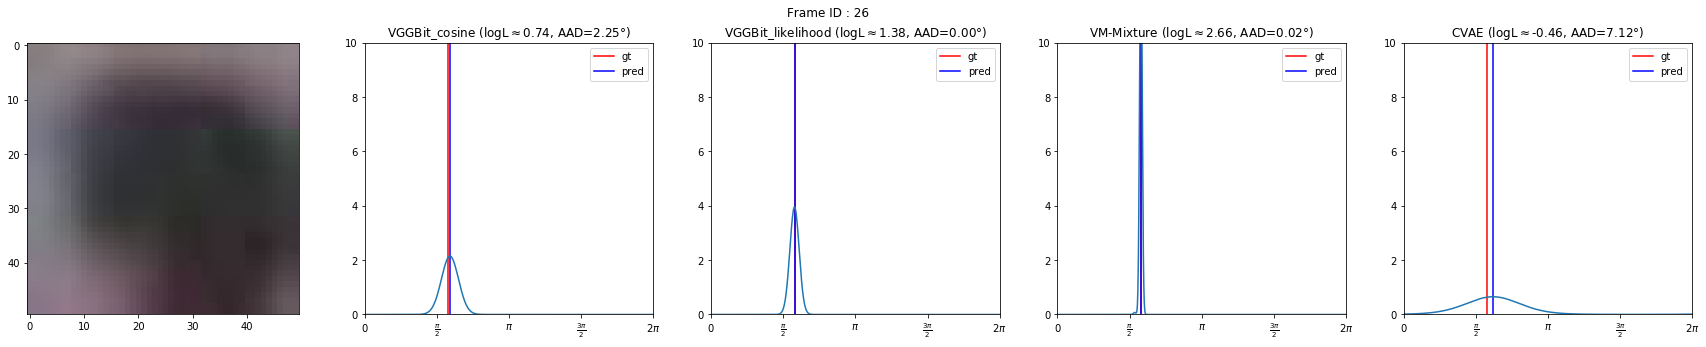

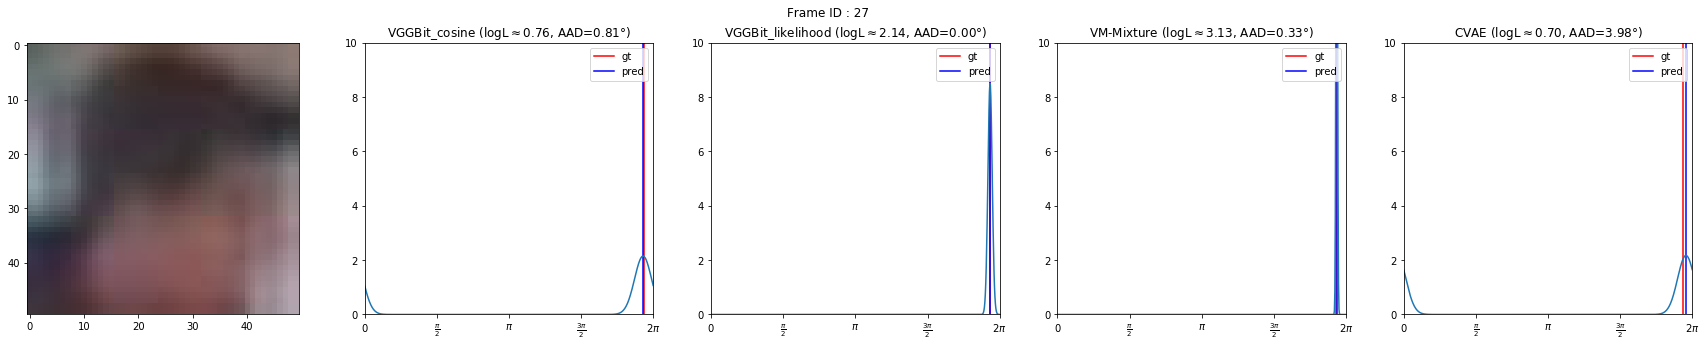

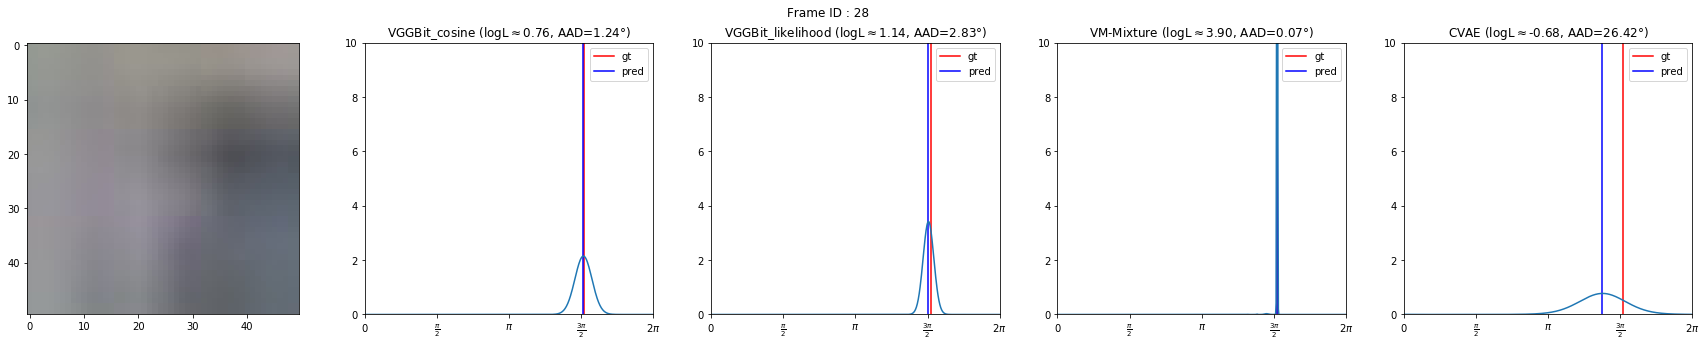

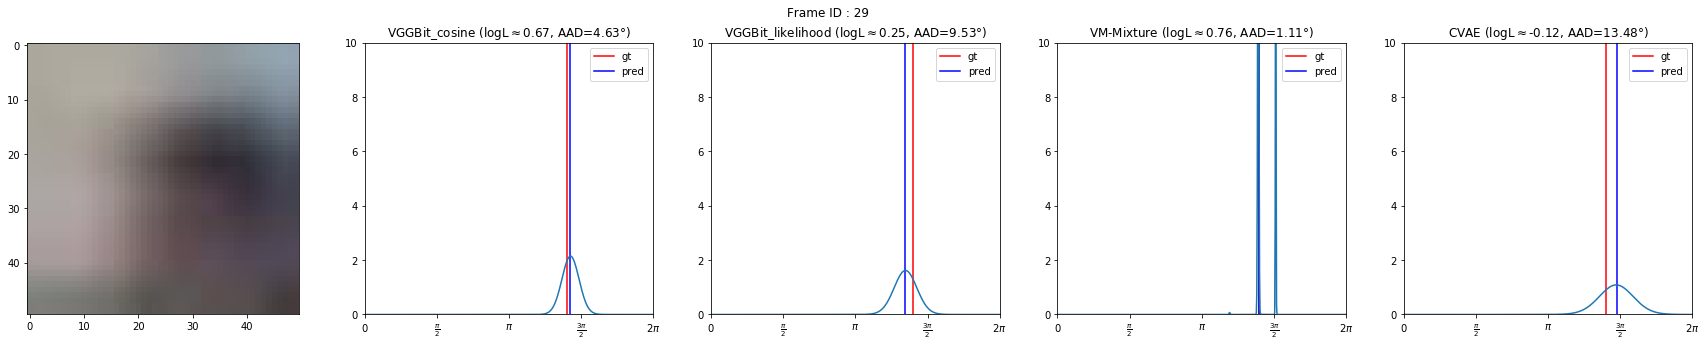

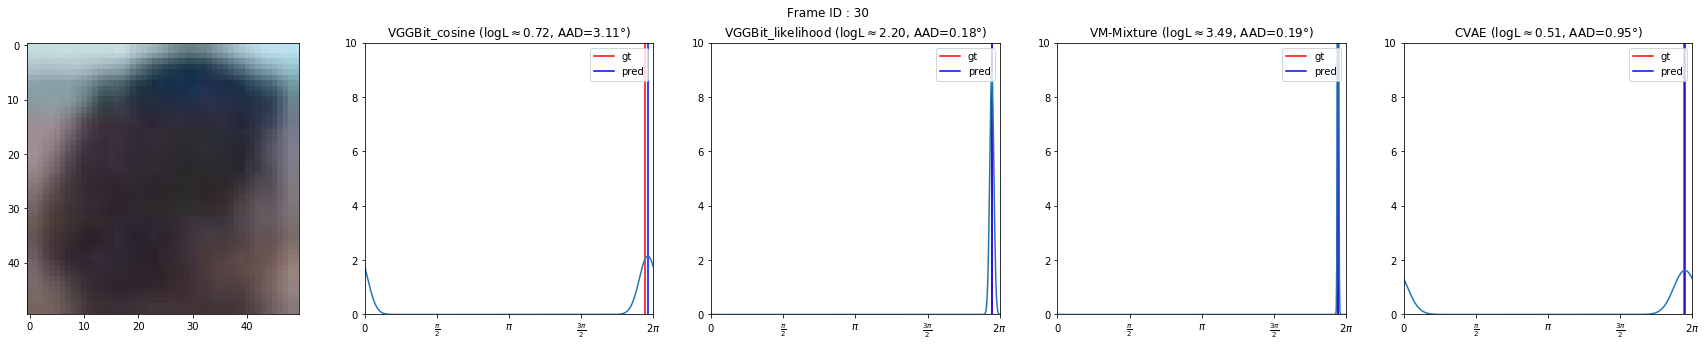

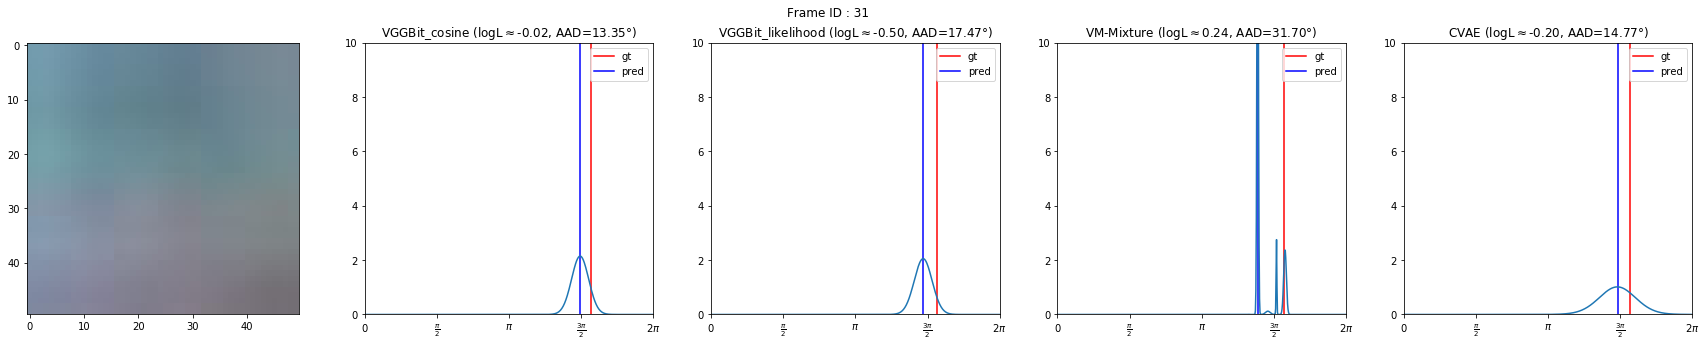

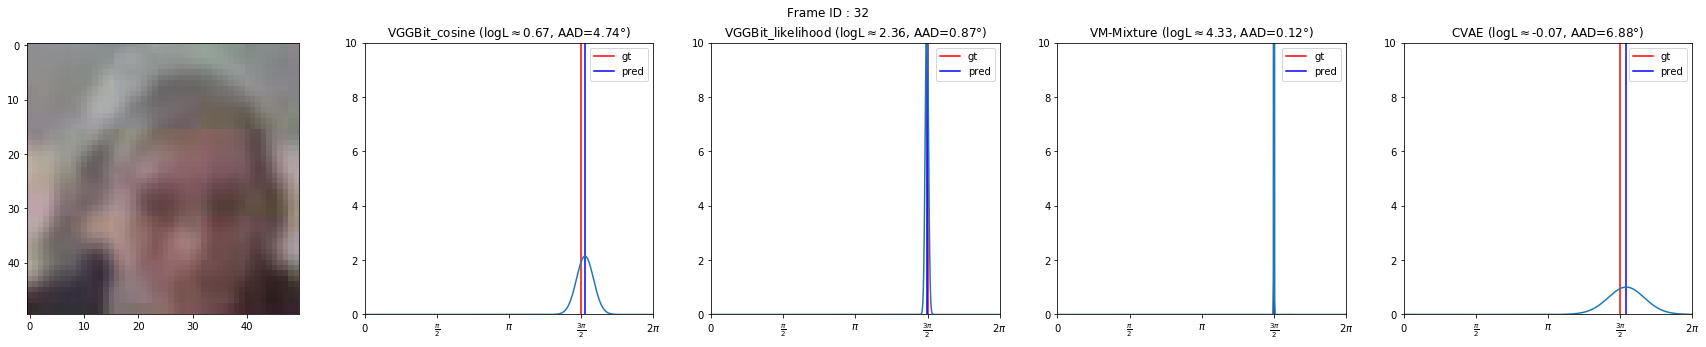

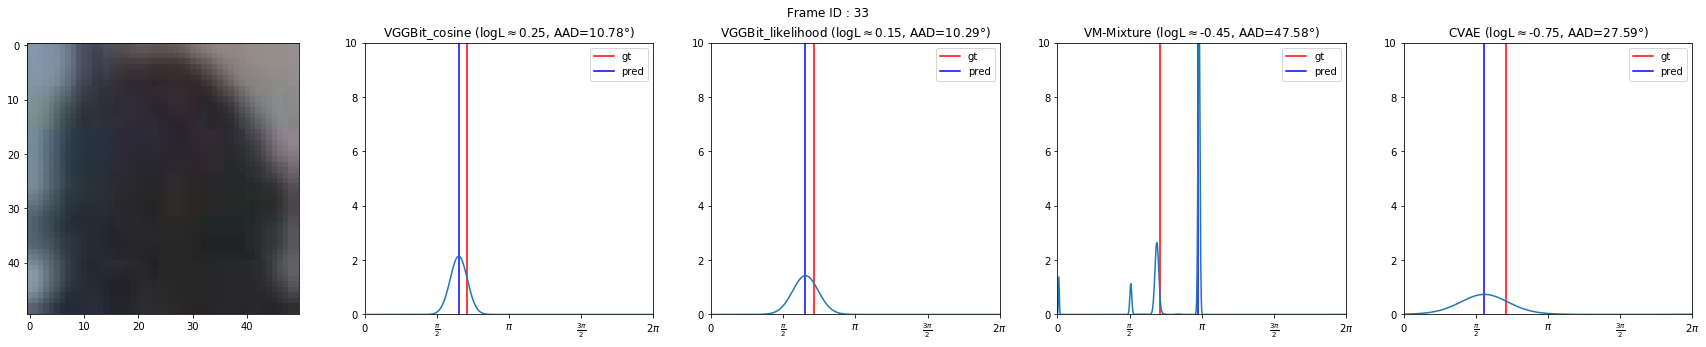

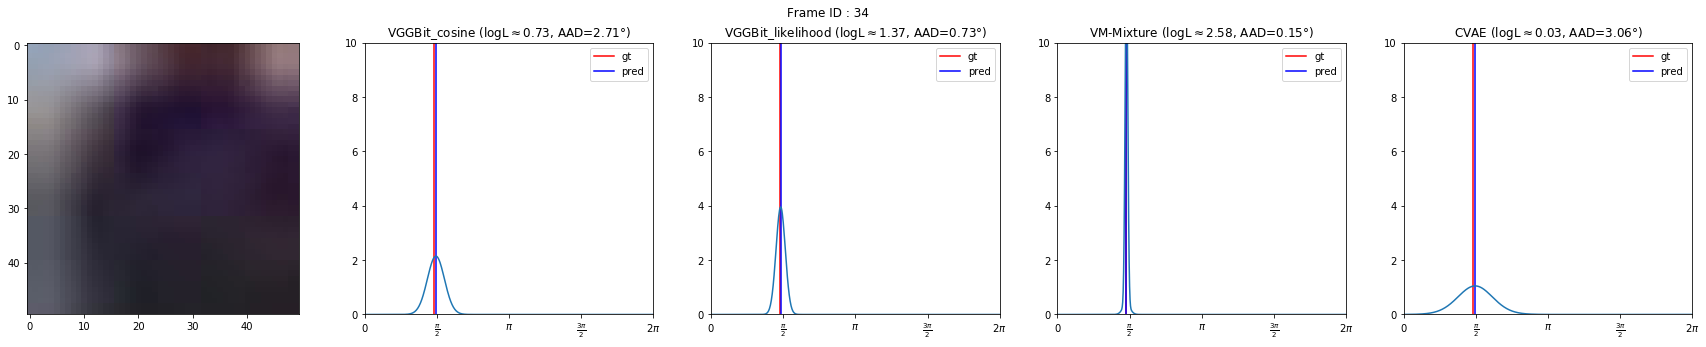

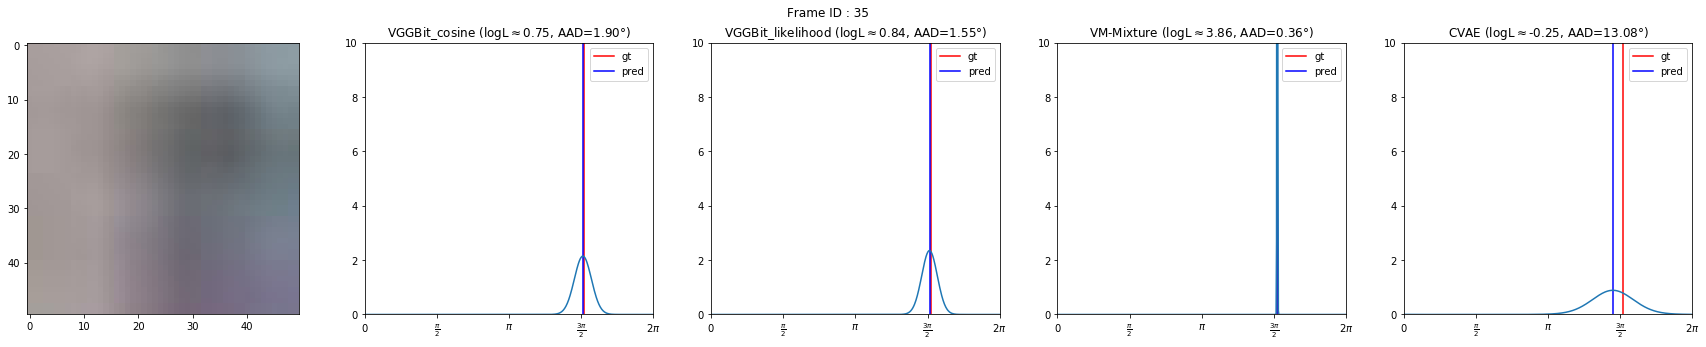

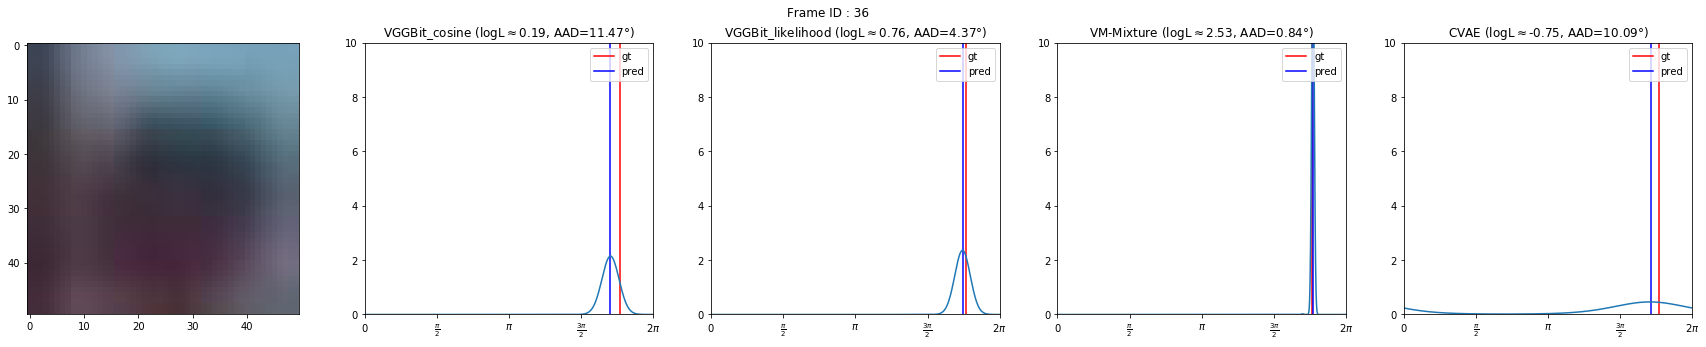

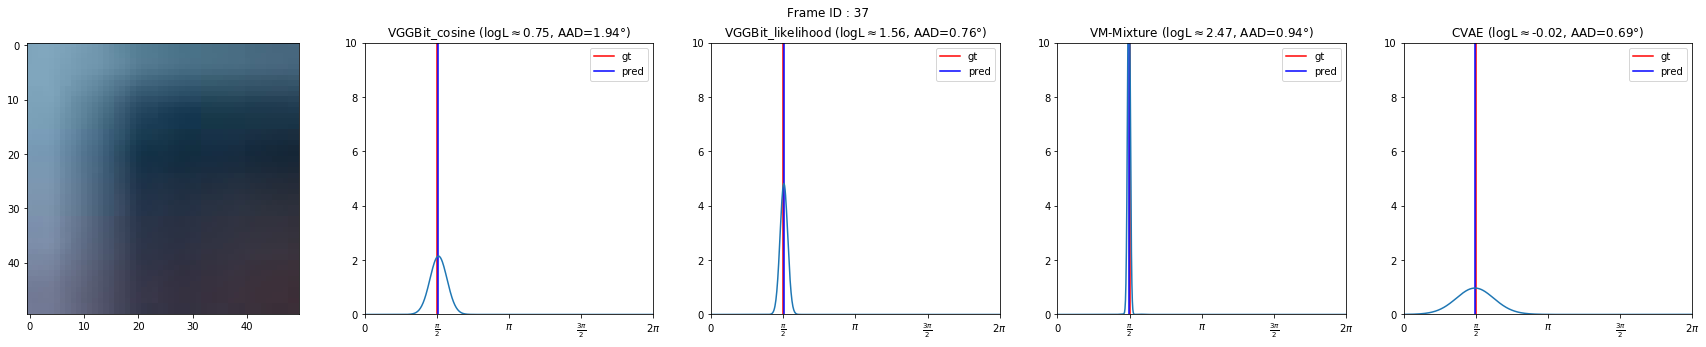

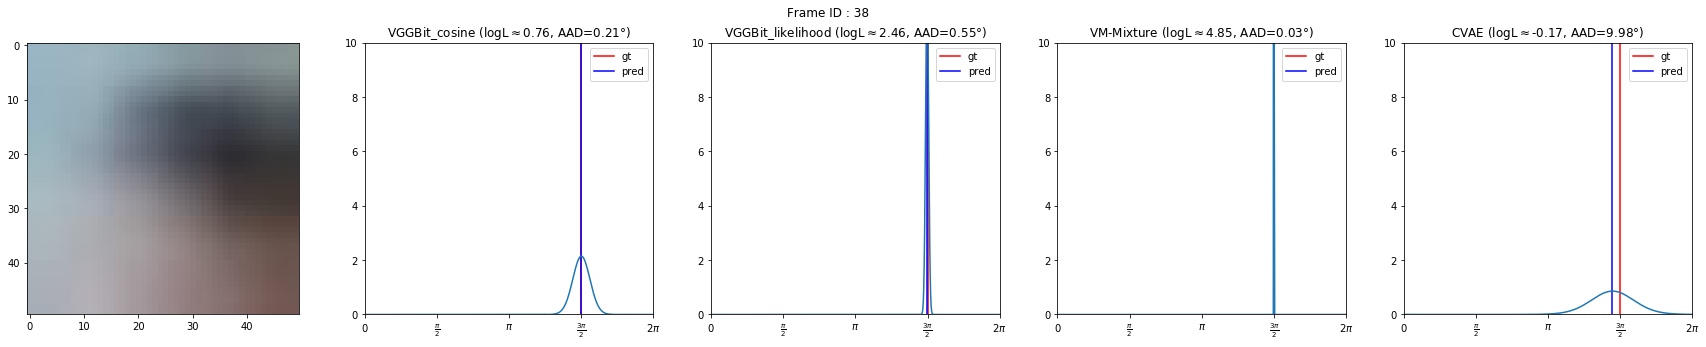

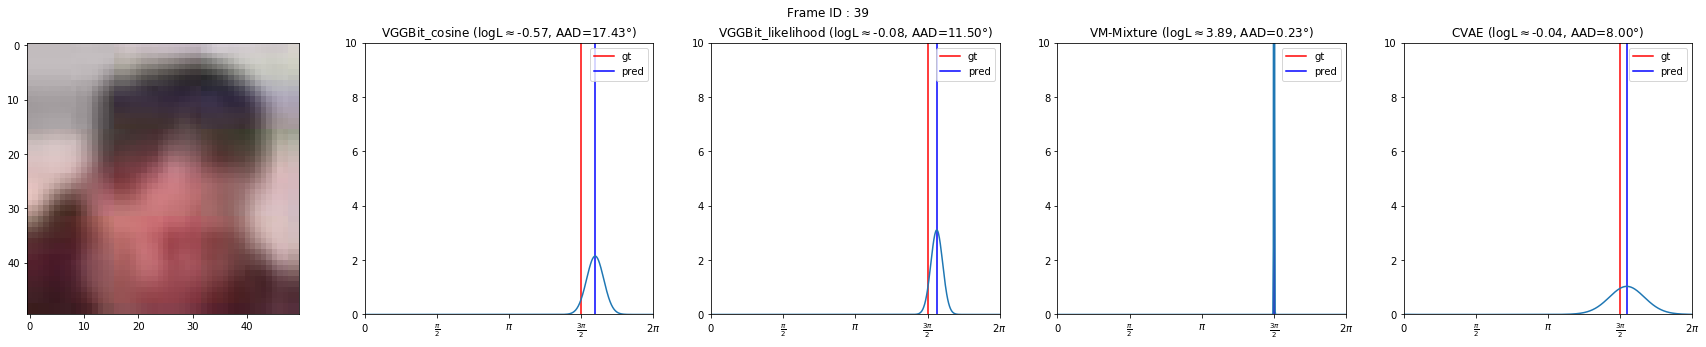

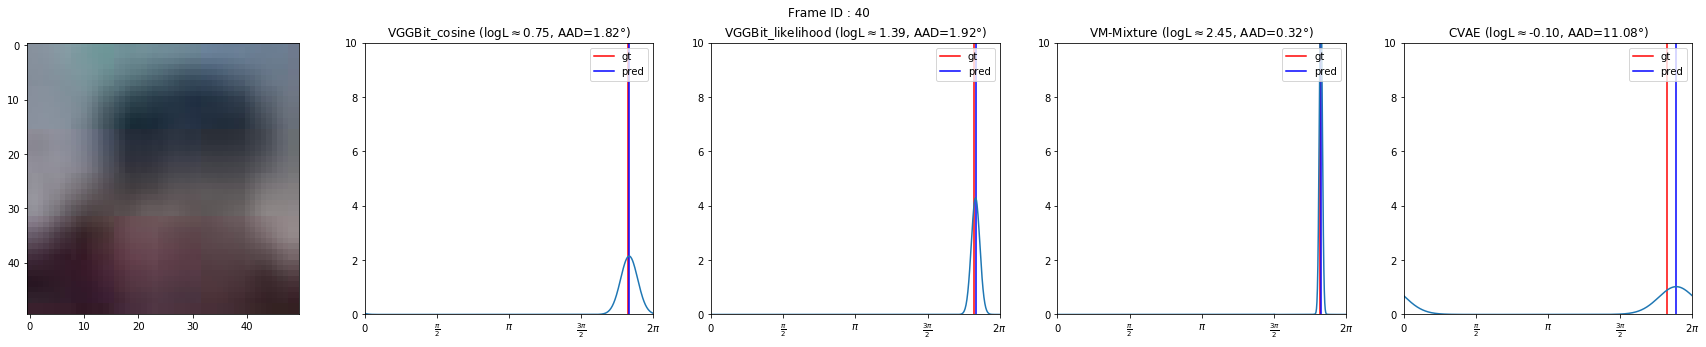

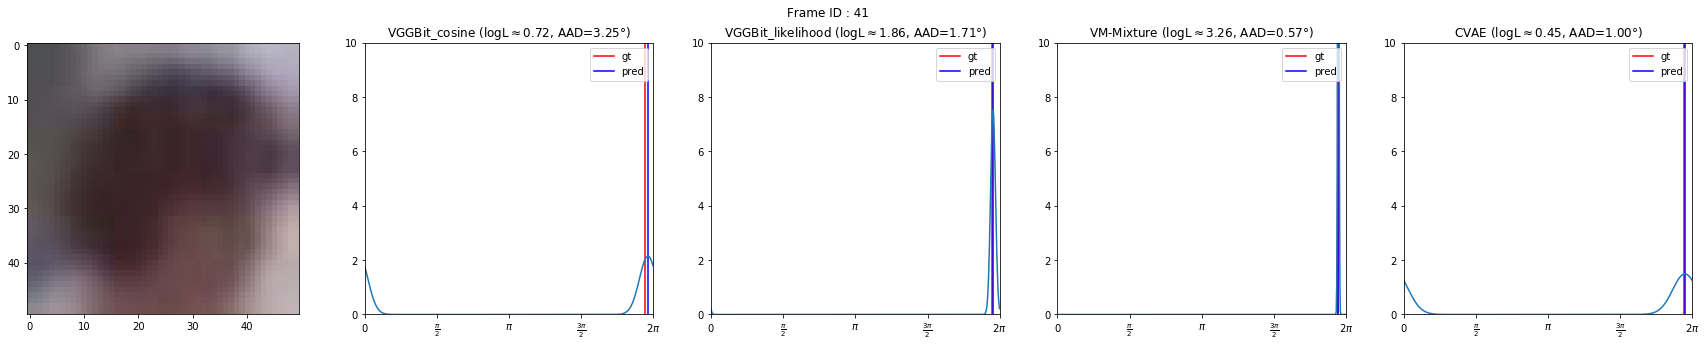

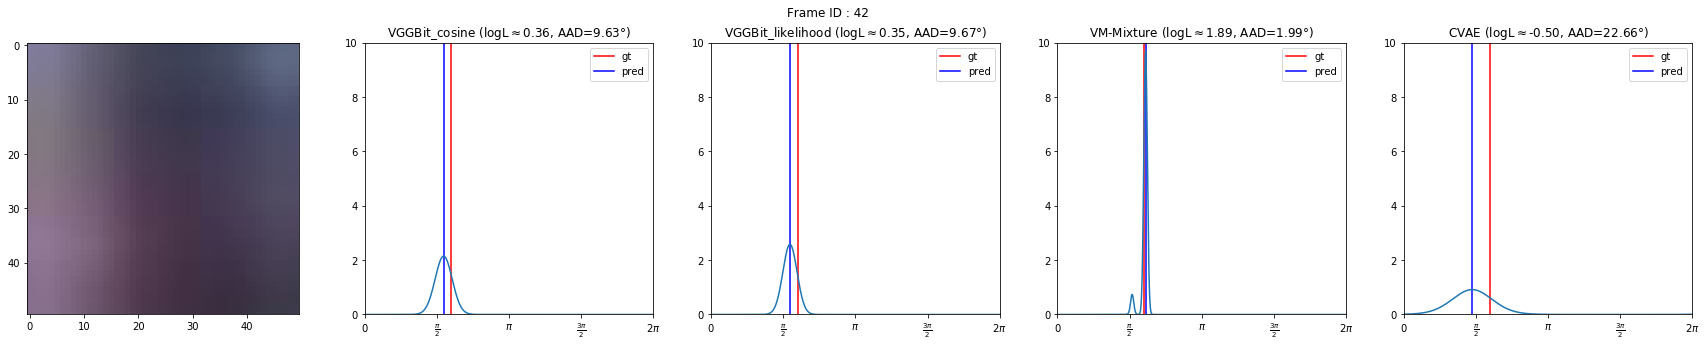

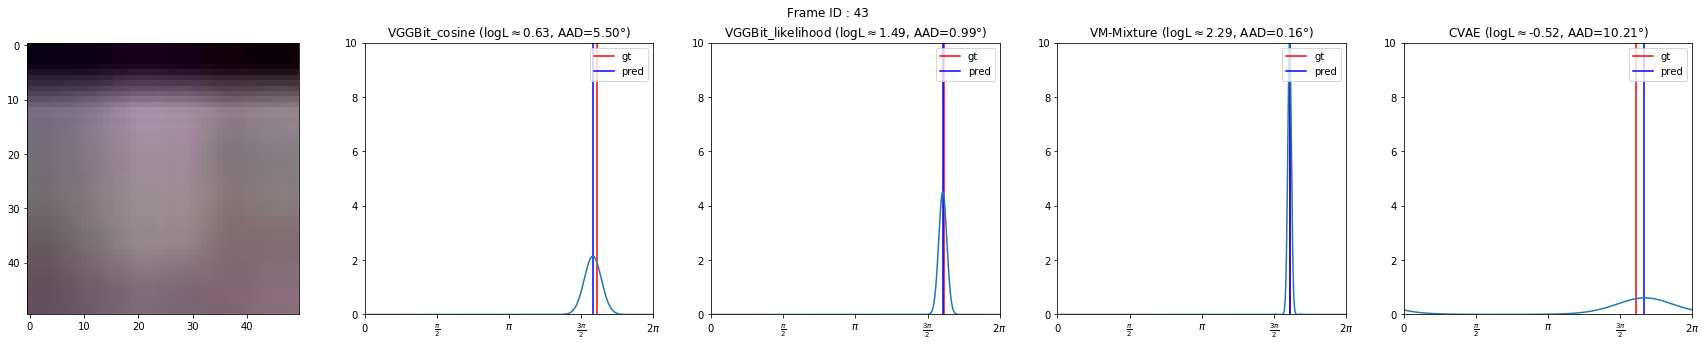

KeyboardInterrupt: 

In [1016]:
from utils.angles import bit2deg

yte_rad = np.deg2rad(bit2deg(yte_bit))

for fix, fid in enumerate(frames[0:100]):
    
    pdfs_dict = {}
    likelihoods_dict = {}
    point_preds_dict = {}
    maad_dict = {}
    pdfs_dict['VGGBit_cosine'] = vggcosine_acc_pdf[fix]
    likelihoods_dict['VGGBit_cosine'] = results['cosine']['log_likelihood'][fix]
    maad_dict['VGGBit_cosine'] = results['cosine']['maad'][fix]
    point_preds_dict['VGGBit_cosine'] = results['cosine']['point_preds'][fix]
    pdfs_dict['VGGBit_likelihood'] = vgglikelihood_acc_pdf[fix]
    likelihoods_dict['VGGBit_likelihood'] = results['likelihood']['log_likelihood'][fix]
    maad_dict['VGGBit_likelihood'] = results['likelihood']['maad'][fix]
    point_preds_dict['VGGBit_likelihood'] = results['likelihood']['point_preds'][fix]
    pdfs_dict['VM-Mixture'] = vmmix_acc_pdf[fix]
    likelihoods_dict['VM-Mixture'] = results['mixture']['log_likelihood'][fix]
    maad_dict['VM-Mixture'] = results['mixture']['maad'][fix]
    point_preds_dict['VM-Mixture'] = results['mixture']['point_preds'][fix]
    pdfs_dict['CVAE'] = cvae_acc_pdfs[fix]
    likelihoods_dict['CVAE'] = results['cvae']['importance_log_likelihood'][fix]
    maad_dict['CVAE'] = results['cvae']['maad'][fix]
    point_preds_dict['CVAE'] = results['cvae']['point_preds'][fix]
    #plot_image_results(xte[fid], xvals, cvae_acc_pdfs[fid], cvae_samples_pdfs[fid], yte_rad[fid])
    plot_image_results(xte[fid], fid, xvals,  pdfs_dict, likelihoods_dict, maad_dict, point_preds_dict, yte_rad[fid])

In [331]:
import numpy as np
import yaml
import os
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 

from utils.load_datasets import load_dataset
from models import vgg
from models.cvae import CVAE
from models.vgg_vmmix import BiternionVGGMixture

from models.cvae import CVAE

cvae_model = CVAE(image_height=image_height,
                 image_width=image_width,
                 n_channels=n_channels,
                 **load_config(cvae_config_path))

xvals =  np.arange(0, 2*np.pi, 0.1)
cvae_samples_pdfs, cvae_acc_pdfs = cvae_model.pdf(xte[0:10], xvals, n_samples=5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

kl_weight : 1.000000



In [ ]:
n_samples = 20

cvae_samples_pdfs, cvae_acc_pdfs = cvae_model.pdf(xte[0:10], xvals, n_samples=n_samples)

fig, axs = plt.subplots(1, 2, figsize=(30, 5))

fid = 2

axs[0].imshow(xte[fid])

for sid in range(0, n_samples):
    plot_pdf(axs[1], xvals, cvae_samples_pdfs[fid, sid,:])

In [922]:
from utils.angles import deg2bit, bit2deg, bit2deg_multi, rad2bit

In [357]:
cvae_model.get_full_output(xte[0:1], yte_bit[0:1])

{'kappa_pred': array([[ 4.73677969]], dtype=float32),
 'log_sigma_encoder': array([[ 0.0086186 , -0.03014129,  0.07822242, -0.01516529, -0.08832328,
         -0.02043993,  0.00202126,  0.01541025]], dtype=float32),
 'log_sigma_prior': array([[  1.66288766e-04,   4.71769163e-04,  -7.29662715e-05,
           2.84797046e-04,  -1.93423970e-04,  -5.83940302e-04,
           3.04388581e-04,  -1.86500110e-04]], dtype=float32),
 'mu_encoder': array([[-0.03757118,  0.06201972, -0.0066931 , -0.04606248,  0.00543232,
         -0.08312672,  0.01495113, -0.02289562]], dtype=float32),
 'mu_pred': array([[ 0.78368002, -0.6211648 ]], dtype=float32),
 'mu_prior': array([[  2.00939830e-04,   4.29551175e-04,  -1.10308290e-03,
          -5.21150534e-04,   4.96007851e-05,   1.37029774e-03,
           1.02136191e-03,   6.34900469e-04]], dtype=float32),
 'u_encoder_samples': array([[ 1.10159791, -1.24182987, -0.08684942, -0.1796615 ,  1.31915724,
          2.31116152, -0.40539676, -0.65336955]], dtype=float32

In [1241]:
np.log(1.2)

0.18232155679395459

In [222]:
from utils.angles import bit2deg

bit2deg(cvae_model.get_full_output(xte[0:1], yte_bit[0:1])['mu_pred'])

array([ 83.60684204], dtype=float32)

In [156]:
cvae_model.get_full_output(xte[0:1], yte_bit[2:1])['kappa_pred']

IndexError: index 0 is out of bounds for axis 0 with size 0

In [163]:
cvae_model.get_full_output(xte[0:1], yte_bit[0:1])['u_encoder_samples']

array([[ 1.50650573,  0.30695483,  0.75444806,  1.11070549, -0.01840132,
        -0.78256691, -0.75187391,  1.95079756]], dtype=float32)

In [1182]:
cvae_model.get_full_output(xte[0:1], yte_bit[0:1])['u_encoder_samples']

array([[ 0.98596197,  0.11848653,  0.79178113, -0.79030037, -0.28618744,
         1.02045012,  0.70742929,  0.24045542]], dtype=float32)

In [975]:
cvae_model.decoder_model.predict(xte[1:2])[:,2]

array([ 1.04503703], dtype=float32)

In [309]:
results['likelihood']['log_likelihood'].shape

(100, 1)